# 6.1 Edmonton AC Loads: Single Simulation Analysis

This toy example is about potential effects of climate change on air conditioning loads in the Canadian city of Edmonton. To start small, this example will focus on a single spatial location, and as such, will demonstrate only *bias-correction* of climate model data, not true spatial downscaling. 

```{note}
Because of the small scope of this example, you should be able to run the code on a personal computer (like all of the previous notebooks). The later examples which involve spatial downscaling will likely require more memory and processing power than a laptop or basic desktop computer can handle.
```
 
## 6.1.1 Preliminary Study Design

Before starting any analysis, some preliminary decisions must be made. The [guided survey provided by the UTCDW](https://utcdw.physics.utoronto.ca/survey/) will help you work through each of the necessary decisions, explained in more detail in Chapter 5 of the UTCDW Guidebook. Herein we'll specify the responses to each survey question, and generate a flowchart that will guide us through the steps of the analysis.

The first few questions of the survey have already been answered, just by defining our study problem. The subject of our study is changes to AC loads in Edmonton, which itself already includes the **spatial domain** we will study. 

Next we need to decide on the time periods of analysis, one to establish the historical baseline from which changes will be measured, and the other to use for future projections. Each period should be at least 30 years long, which is the standard for establishing climate normals. For the historical baseline, we will choose **1980-2010**. This period is entirely covered by the historical CMIP6 simulations, which end in the year 2015. It also will allow us to later use the NRCanMet gridded observational data from PCIC, which is only available up to the year 2010. For the future period, we'll use the end-of-century period **2070-2100**. For a practical study, you might be interested in a closer-term future period, but using an end-of-century period for this pedagogical will maximize the strength of the signal.

For our future period, we must also specify one or more future scenarios to study, since of course we cannot know exactly what future emissions of climate forcers like greenhouse gases will be. To continue with the theme of starting small, we'll begin with data from only one model and one future scenario to develop our code. After going through the whole bias-correction workflow with this model, we'll expand the analysis to include multiple models and scenarios.

The scenario we will start with is SSP3-7.0. This is a high emissions scenario (but not the highest) and represents a future of "Regional Rivalry" where countries focus on their own economic goals instead of international cooperation on environmental issues. 

The modle we'll begin with is the [NCAR Community Earth System Model version 2](https://www.cesm.ucar.edu/models/cesm2). CESM2 is a state-of-the-art Earth System Model contributing to CMIP6, and is developed by a large team of scientists in the USA. The results from this model aren't particularly special in the context of the CMIP6 ensemble, though it does have an [equilibrium climate sensitivity towards the higher end of the CMIP6 spectrum](https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained/). As mentioned, we'll later expand this analysis to include multiple CMIP6 models.

Now we must specify our **climate indicator** - the way we'll quantify AC loads as a function of climatic variables. A standard climate indicator which was developed to be a proxy for AC loads is **cooling degree days**, or CDDs. CDDs measure the cumulative annual AC load by summing the amount by which the daily mean temperature exceeds a certain threshold, on days when that threshold is exceeded. The formula is as follows:

$$
CDD = \sum_{i=1}^{365}\left(T_{i} - T_{thresh}\right) I\left(T_{i} > T_{thresh} \right)
$$

Where $I(x)$ is the indicator function, taking value 1 when $x$ is true and $0$ when $x$ is false. The usual value for $T_{thresh}$ is 18$^{\circ}$C. Remember that $T_{i}$ is the *daily mean* temperature. You may not usually turn on your AC when the temperature is 18$^{\circ}$C, but the peak afternoon temperature on such a day is likely to be much warmer than 18$^{\circ}$C because of the diurnal cycle. 

Knowing how to calculate CDDs has answered the next few survey questions for us: the input variable is **surface air temperature**, with time samplig of **daily averages**. 

Finally, we must specify the spatial sampling for our data. In this example, we're interested in projections for a single discrete location, being the site of an **ECCC weather station** from which we'll draw observations of daily mean temperature. As mentioned, a later example will use gridded observations to produce downscaled results for an extended region, but this first example will start simple and demonstrate the workflow for a small case.

Having answered all of the survey questions, we can use the UTCDW website to generate a flowchart that explains the steps of our analysis:


```{image} ./figures/survey_station_cesm2.png 
:width: 600px
:align: center
```

The top half of the flowchart contains the answers to the survey questions, regarding the data we've chosen to use. These decisions feed into the analysis steps on the bottom half of the flowchart, which is standardized. Of course, there remain decisions to be made regarding the important aspects of the model data to validate, and your method of bias-correction/downscaling, but these can be dealt with after having decided on which datasets to use, and may become more apparent after doing exploratory analysis with the data.


## 6.1.2 Selecting and Downloading the Datasets

Having decided on the scope of the project, and some details that constrain the datasets that will be used in the study, we can start acquiring the data. Let's begin with the observational dataset: ECCC weather station observations for a single site in Edmonton. We will use the `ec3` package to search for an appropriate station and download the data. Then we'll do some data cleaning with `pandas`, and eventually convert the station data into `xarray` format so it can be processed in the same way as the model data, and be used with `xclim` for bias correction and calculating the climate indicator.

In [1]:
import xarray as xr
from xclim import sdba
from xclim.core.calendar import convert_calendar
import xclim.indices as xci
import xclim.ensembles as xce
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import ec3
import gcsfs
import zarr

# lat and lon coordinates for Edmonton
lat_edm = 53.5
lon_edm = -113.5

# time periods for historical and future periods
years_hist = range(1980, 2011) # remember that range(start, end) is not inclusive of `end`
years_future = range(2070, 2101)

# url for the CSV file that contains the data catalog
url_gcsfs_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'

In [2]:
# search for stations near our desired location
find_stn_results = ec3.find_station(target = (lat_edm, lon_edm), 
                                    period = range(1980, 2011),
                                    type = 'daily',
                                    dist = range(25),
                                    detect_recodes = True)


/Users/mikemorris/opt/anaconda3/envs/UTCDW-env/lib/python3.10/site-packages/ec3.py:105: UserWarning: Cannot find the station inventory in the current working directory.
  warnings.warn("Cannot find the station inventory in the current working directory.")


Note: In addition to the stations found, the following combinations may provide sufficient baseline data.


>> Combination 1 at coordinates 53.57 -113.52 

Station 1864 : EDMONTON CALDER (1975-1977)
Station 1867 : EDMONTON CITY CENTRE A (1937-2005)
Station 27214 : EDMONTON BLATCHFORD (1996-2023)
Station 31427 : EDMONTON CITY CENTRE AWOS (2005-2015)




In [3]:
find_stn_results

,Name,Province,Climate ID,Station ID,WMO ID,TC ID,Latitude (Decimal Degrees),Longitude (Decimal Degrees),Latitude,Longitude,Elevation (m),First Year,Last Year,DLY First Year,DLY Last Year,Dist
2429,EDMONTON WOODBEND,ALBERTA,3012230,1872,NaN,NaN,53.42,-113.75,532500000.0,-1.134500e+09,670.6,1973,2015,1973.0,2015.0,18.84175793351712 km
2416,EDMONTON INT'L A,ALBERTA,3012205,1865,71123.0,YEG,53.32,-113.58,531900000.0,-1.133500e+09,723.3,1959,2012,1959.0,2012.0,20.72726507003484 km


To focus on an urban area where any change to CDDs is likely to have the most impact on people and building enetgy use, we'll use the Edmonton City Centre station. This means combining data from Station IDs 1867 and 31427, to fit our whole historical reference period.

In [4]:
def download_station_data(stn_id, years = range(1992, 2022)):
    """
    Download ECCC observational data at the weather station identified with stn_id,
    re-name the columns to more useful names. Optional: select specific years of data,
    but by default, download all data from 1990--2020.
    """
    # download the data
    df = ec3.get_data(stn_id, years = years, progress = False)
    
    # dictionary mapping original column names to new ones
    column_name_dict = {'Date/Time': 'time', 
                        'Mean Temp (°C)': 'tas',
                        'Latitude (y)': 'lat',
                        'Longitude (x)': 'lon',
                        'Station Name': 'Name'}
    
    df = df.rename(columns = column_name_dict)
    
    # select only the variables we re-named - you can comment this out if you want to keep all variables
    df = df[list(column_name_dict.values())]
    
    # set the "time" column as an index column and convert it from strings to Datetime objects to make
    # selecting times easier
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index("time")
    
    # sort the data in proper chronological order
    df = df.sort_index()
    
    df = df.dropna()
    
    return df

In [5]:
# download the station data
stn_id_list = [1867, 31427]
df_list = []
for stn_id in stn_id_list:
    df = download_station_data(stn_id, years = years_hist)
    # print first and last timestep so we can check if there is any time overlap
    # between the two records
    print(stn_id, f"start: {df.index.values.min()}", f"end: {df.index.values.max()}")
    df_list.append(df)


1867 start: 1980-01-01T00:00:00.000000000 end: 2005-01-20T00:00:00.000000000


31427 start: 2005-01-21T00:00:00.000000000 end: 2010-12-31T00:00:00.000000000


In [6]:
# the above output shows no overlap in time between the two stations, so we can safely
# concatenate them without dropping any data from one or the other
stn_df = pd.concat(df_list, axis = 0)

# now convert it to xarray format for easier use with the model data and xclim

# drop lat and lon variables, since we want these to be coordinates in the xr.Dataset
stn_lon = stn_df.lon.values[0] + 360 # convert lon to same convention as model data
stn_lat = stn_df.lat.values[0] 

stn_df = stn_df.drop(['lat', 'lon'], axis = 1)

stn_ds = xr.Dataset.from_dataframe(stn_df)
stn_ds = stn_ds.assign_coords(lat = stn_lat, lon = stn_lon)
stn_ds

<xarray.Dataset>
Dimensions:  (time: 11214)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2010-12-31
    lat      float64 53.57
    lon      float64 246.5
Data variables:
    tas      (time) float64 -9.4 -5.8 -10.3 -11.8 ... -11.0 -17.6 -18.0 -19.0
    Name     (time) object 'EDMONTON CITY CENTRE A' ... 'EDMONTON CITY CENTRE...

Having downloaded the station observational data, the next step is to download the raw model data. Since it tends to be more reliable than the ESGF, we'll search the Google Cloud Services CMIP6 archive for data from our chosen model and scenarios.

In [7]:
# open the Google Cloud model data catalog with pandas
df_catalog = pd.read_csv(url_gcsfs_catalog)

# search for our selected model, both historical and SSP3-7.0 scenarios
search_string = "table_id == 'day' & source_id == 'CESM2' & variable_id == 'tas'" # continue on the next line
search_string += " & experiment_id == ['historical', 'ssp370']"
df_search = df_catalog.query(search_string)

# print a summary of the resulting dataframe, click to reveal
df_search 


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
58919,CMIP,NCAR,CESM2,historical,r1i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61527,CMIP,NCAR,CESM2,historical,r5i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
61604,CMIP,NCAR,CESM2,historical,r4i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61627,CMIP,NCAR,CESM2,historical,r3i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
62145,CMIP,NCAR,CESM2,historical,r6i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
63061,CMIP,NCAR,CESM2,historical,r2i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
64025,CMIP,NCAR,CESM2,historical,r7i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...,NaN,20190311
65331,CMIP,NCAR,CESM2,historical,r9i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...,NaN,20190311
65878,CMIP,NCAR,CESM2,historical,r8i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311
66385,CMIP,NCAR,CESM2,historical,r10i1p1f1,day,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313


Because it has simulations available for both the `historical` and `ssp370` experiments, we'll start with the ensemble member `r10i1p1f1`. For this ensemble member of CESM2, we'll download the `tas` data from Google Cloud, interpolate it to the coordinates of our station, and select the time periods for the study. For the historical scenario, this will be 1980--2010, the same time period as we chose for the station observations. For the future period, we'll use an end-of-century period, 2070-2100. 

In [8]:
# filter the search results further for the ensemble member we want to use
df_search_r10i1p1f1 = df_search.query("member_id == 'r10i1p1f1'")

# authenticate access to Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')

# get the URLs for each dataset and turn into zarr store mappers
url_hist = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'historical'].zstore.values[0]
mapper_hist = gcs.get_mapper(url_hist)
url_ssp3 = df_search_r10i1p1f1[df_search_r10i1p1f1.experiment_id == 'ssp370'].zstore.values[0]
mapper_ssp3 = gcs.get_mapper(url_ssp3)


In [9]:
# download the datasets and interpolate data to the station coordinates

# historical
ds_hist_raw = xr.open_zarr(mapper_hist, consolidated = True)
tas_hist_raw = ds_hist_raw.tas.interp(lat = stn_lat, lon = stn_lon) - 273.15 # also convert to C

# future
ds_ssp3_raw = xr.open_zarr(mapper_ssp3, consolidated = True)
tas_ssp3_raw = ds_ssp3_raw.tas.interp(lat = stn_lat, lon = stn_lon) - 273.15 

# select time periods
tas_hist_raw = tas_hist_raw.sel(time = tas_hist_raw.time.dt.year.isin(years_hist)).load()
tas_ssp3_raw = tas_ssp3_raw.sel(time = tas_ssp3_raw.time.dt.year.isin(years_future)).load()

## 6.1.3 Assessing Model-Obs Consistency

Now that we've aquired the model data for our study location, and for the right time periods, we can take a peek at the data and compare the raw model simulations to the observations. This will help us characterize the bias in the raw historical simulations, plus the climate change signal in the raw model projections relative to the historical simulation. First let's plot the daily climatologies for each dataset, all on the same axes.

In [10]:
# calculate daily climatologies

# station
tas_dailyclim_obs = stn_ds.tas.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = stn_ds.tas.groupby('time.dayofyear').std('time').compute()

# raw historical
tas_dailyclim_hist_raw = tas_hist_raw.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_hist_raw = tas_hist_raw.groupby('time.dayofyear').std('time').compute()


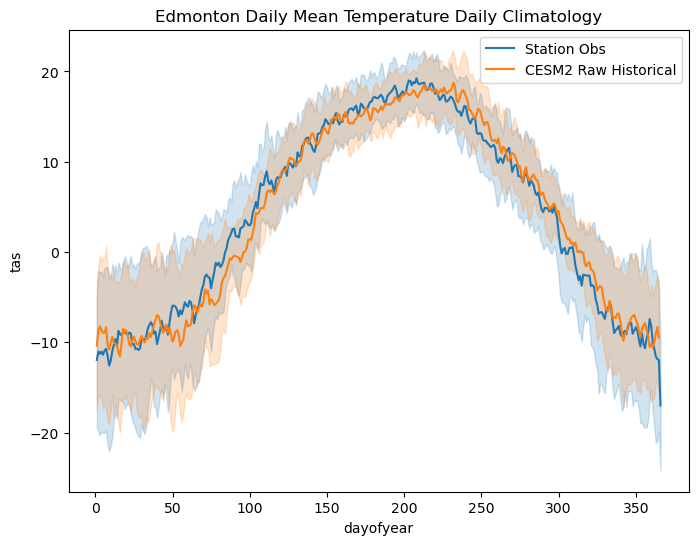

In [11]:
# plot daily climatologies for historical simulation and obs
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'tab:blue')
tas_dailyclim_hist_raw.plot.line(ax = ax, label = "CESM2 Raw Historical", color = 'tab:orange')

# 1 sigma shading

# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'tab:blue')
# raw historical
ax.fill_between(tas_dailyclim_hist_raw.dayofyear, 
                tas_dailyclim_hist_raw - tas_dailyclim_std_hist_raw, 
                tas_dailyclim_hist_raw  + tas_dailyclim_std_hist_raw,
                alpha = 0.2, color = 'tab:orange')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.legend()
plt.show()

Strange, the observed data drops to a very low value at the end of the year, and extends past the model data on the x axis. This is because the model calendar does not include leap years! To account for this discrepancy, we will drop leap days from the station data to rectify the difference in calendars, and then re-do the calculation.

In [12]:
# calculate station daily climatology again after converting its calendar to match the model
stn_ds_noleap = convert_calendar(stn_ds, 'noleap')
tas_obs_noleap = stn_ds_noleap.tas

tas_dailyclim_obs = tas_obs_noleap.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_obs = tas_obs_noleap.groupby('time.dayofyear').std('time').compute()

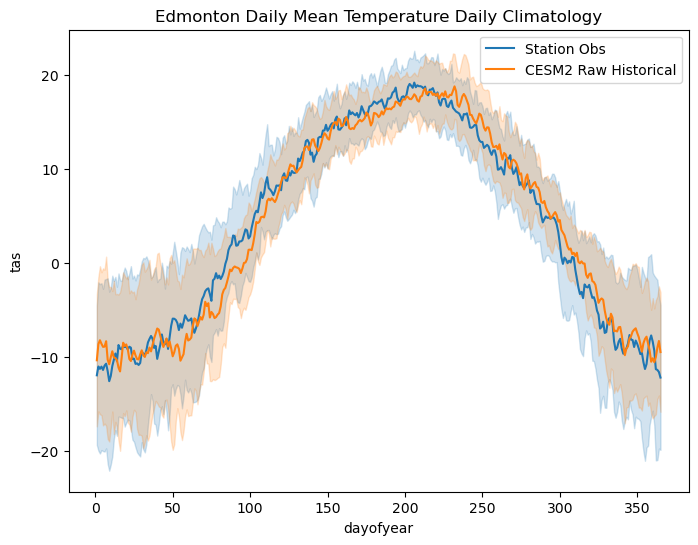

In [13]:
# plot daily climatologies for historical simulation and obs
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'tab:blue')
tas_dailyclim_hist_raw.plot.line(ax = ax, label = "CESM2 Raw Historical", color = 'tab:orange')

# 1 sigma shading

# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'tab:blue')
# raw historical
ax.fill_between(tas_dailyclim_hist_raw.dayofyear, 
                tas_dailyclim_hist_raw - tas_dailyclim_std_hist_raw, 
                tas_dailyclim_hist_raw  + tas_dailyclim_std_hist_raw,
                alpha = 0.2, color = 'tab:orange')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.legend()
plt.show()

This second plot is a more fair comparison of the daily climatologies. The model bias for this location (i.e. the difference between the obs and the historical simulation) isn't especially large in this case, which is encouraging. The daily climatoloies do not agree perfectly, most notably in the summertime when the model historical climatology peaks later in the year than the observed climatology, but the one-standard-deviation (one-$\sigma$) ranges overlap a lot. We'll continue to characterize the model bias in the next step by plotting the PDFs and CDFs of daily mean temperature for both datasets. 


In [14]:
# fit Kernel Density Estimator so we can plot a smooth distribution
kde_hist_raw = stats.gaussian_kde(tas_hist_raw.values)
kde_obs = stats.gaussian_kde(tas_obs_noleap.values) 

# means and stdev ratios
tas_hist_raw_mean = tas_hist_raw.mean('time').compute()
tas_obs_mean = tas_obs_noleap.mean('time').compute()

# stdevs for each dataset
tas_hist_raw_stdev = tas_hist_raw.std('time').compute()
tas_obs_stdev = tas_obs_noleap.std('time').compute()


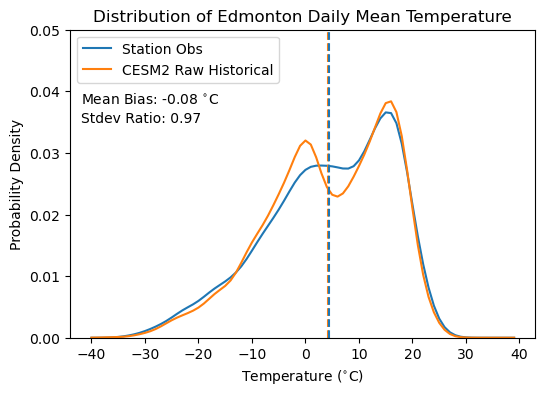

In [15]:
# plot the PDFs smoothed by KDE
temperatures = np.arange(-40, 40)
plt.figure(figsize = (6,4))
plt.title("Distribution of Edmonton Daily Mean Temperature")
plt.plot(temperatures, kde_obs(temperatures), label = 'Station Obs', color = 'tab:blue')
plt.plot(temperatures, kde_hist_raw(temperatures), label = 'CESM2 Raw Historical', color = 'tab:orange')
plt.vlines([tas_hist_raw_mean, tas_obs_mean], 0, 1, colors = ['tab:orange', 'tab:blue'], linestyles = '--')
plt.ylim(0, 0.05)
plt.xlabel(r"Temperature ($^{\circ}$C)")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper left')

# annotate with mean bias and ratio of stdevs
plt.text(-42, 0.038, r'Mean Bias: %.2f $^{\circ}$C' % (tas_hist_raw_mean - tas_obs_mean))
plt.text(-42, 0.035, r'Stdev Ratio: %.2f' % (tas_hist_raw_stdev / tas_obs_stdev))

plt.show()

This situation is similar to Section 3.4.4 where we compared the temperature distributions for Toronto between CanESM5 and the Toronto City ECCC station. Here the mean bias is small and the overall variability is similar, but the model (CESM2) distribution is sharply bimodal while the observed temperature distribution is less so. This feature of the bias in the model temperatures cannot be determined by comparing the daily climatologies, but it's important to account for. Thankfully, our quantile mapping based bias correction methods (like Quantile Delta Mapping) can help correct for this. Later on we'll reproduce this plot with bias-corrected model data to see if it helps correct for the spurious bimodality of the daily mean temperature distribution.

The next thing to check in regards to model/obs agreement is our climate indicator, cooling degree days (CDDs).  If your indicator requires high spatial resolution to calculate (e.g. if you need high-resolution inputs for a complex impacts model), then you won't be able to do this step. Because CDDs are calculated using a simple formula and this can be calculated from a 1D timeseries of daily mean temperature, there's no reason why we can't compare the results from the raw model output to the observed values. We will use the standard temperature threshold of 18$^{\circ}$C in our calculation of CDDs (which is the default for `xclim.indices.cooling_degree_days`).

In [16]:
# add unit attributes to tas data for use with xclim routines
tas_obs_noleap.attrs['units'] = 'degC'
tas_hist_raw.attrs['units'] = 'degC'

# calculate CDDs
cdd_obs = xci.cooling_degree_days(tas_obs_noleap).compute()
cdd_hist_raw = xci.cooling_degree_days(tas_hist_raw).compute()

# long-term means for the historical period
cdd_obs_ltm = cdd_obs.mean('time').compute()
cdd_hist_raw_ltm = cdd_hist_raw.mean('time').compute()

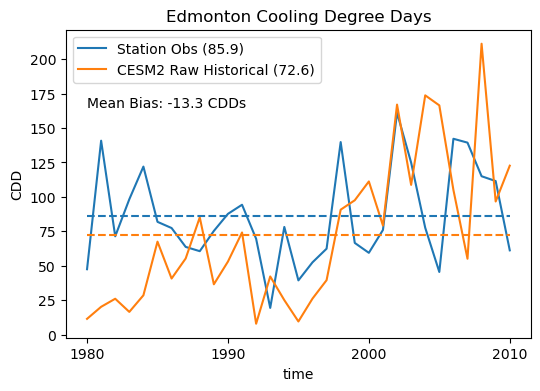

In [17]:
# plot timeseries of CDDs for model historical and obs
fig, ax = plt.subplots(figsize = (6, 4))
cdd_obs.plot.line(label = "Station Obs (%.1f)" % cdd_obs_ltm.values, color = 'tab:blue')
cdd_hist_raw.plot.line(label = "CESM2 Raw Historical (%.1f)" % cdd_hist_raw_ltm.values, color = 'tab:orange')

# plot long-term means
ax.hlines([cdd_obs_ltm.values, cdd_hist_raw_ltm.values], 
          cdd_obs.time.min().values, cdd_obs.time.max().values, 
          colors = ['tab:blue', 'tab:orange'], linestyles = '--')

ax.set(title = "Edmonton Cooling Degree Days", ylabel = "CDD")
ax.legend()

# show the mean bias on the plot
ax.text(cdd_obs.time[0].values, 165, "Mean Bias: %.1f CDDs" % (cdd_hist_raw_ltm.values - cdd_obs_ltm.values))
plt.show()

Despite good agreement regarding the daily climatology and the overall mean and standard deviation, the model shows a fairly sizable bias in the number of annual CDDs. 13 CDDs per year, compared to the observed long-term mean of about 86 CDDs per year, is a mean bias of about 15%. Going through the exercise of calculating the climate indicator using the raw model data has illuminated this important bias, which wouldn't be easily deduced by examining at the previous plots. The spurious low-temperature peak of the model PDF hints that there may be too few warm days, but we couldn't make this conclusion without calculating the CDDs.

## 6.1.4 Evaluating the Climate Change Signal

Having characterized the model bias using the historical simulation and the observations, it is time to evaluate the climate change projections of the raw model simulations. First we will plot the daily climatology of the SSP3-7.0 end-of-century projections, and compare to the historical period model daily climatology.

In [18]:
# daily climatology for raw SSP3-7.0
tas_dailyclim_ssp3_raw = tas_ssp3_raw.groupby('time.dayofyear').mean('time').compute()
tas_dailyclim_std_ssp3_raw = tas_ssp3_raw.groupby('time.dayofyear').std('time').compute()

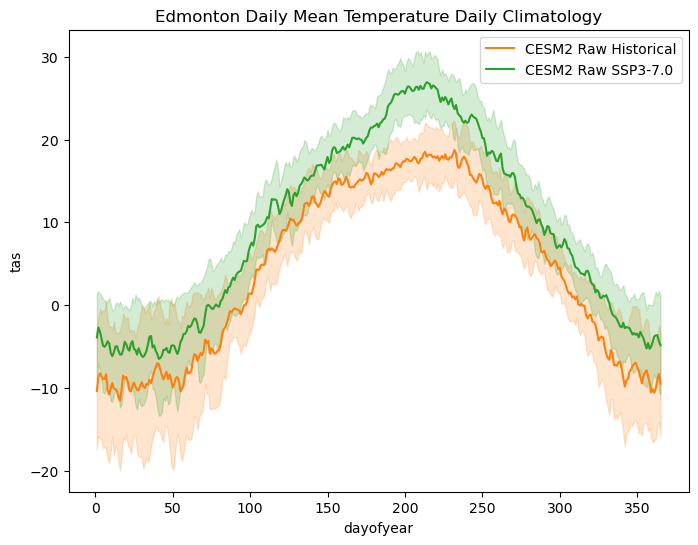

In [19]:
# plot daily climatologies for both model simulations
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_hist_raw.plot.line(ax = ax, label = "CESM2 Raw Historical", color = 'tab:orange')
tas_dailyclim_ssp3_raw.plot.line(ax = ax, label = "CESM2 Raw SSP3-7.0", color = 'tab:green')

# 1 sigma shading
# raw historical
ax.fill_between(tas_dailyclim_hist_raw.dayofyear, 
                tas_dailyclim_hist_raw - tas_dailyclim_std_hist_raw, 
                tas_dailyclim_hist_raw  + tas_dailyclim_std_hist_raw,
                alpha = 0.2, color = 'tab:orange')
# raw SSP3-7.0
ax.fill_between(tas_dailyclim_ssp3_raw.dayofyear, 
                tas_dailyclim_ssp3_raw - tas_dailyclim_std_ssp3_raw,
                tas_dailyclim_ssp3_raw + tas_dailyclim_std_ssp3_raw,
                alpha = 0.2, color = 'tab:green')

ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.legend()
plt.show()

We see clear signs of warming in the end-of-century period under the SSP3-7.0 scenario, especially in the summer season. The low end of the one-$\sigma$ range for this case is completely above the high end of the variability range for the model historical case. This is likely to result in large changes in our climate indicator, cooling degree days. 

Before calculating the change in CDDs for the raw model output, let's first test the statstical significance of the climate change signal, using the methods from Section 3.4.5.1. We'll use the Students' $t$-test, with correction for temporal autocorrelation, to test for an increase to the mean temperature.

In [20]:
# calculate mean and stdev for future
tas_ssp3_raw_mean = tas_ssp3_raw.mean('time')
tas_ssp3_raw_stdev = tas_ssp3_raw.std('time')

In [21]:
# calculate effective sample size for historical and future periods
def effective_sample_size(data):
    ntime = len(data.time)
    # times not including the final timestep
    times = data.time.isel(time = slice(0, ntime - 1))
    # data not including the first timestep
    data_lag = data.isel(time = slice(1, ntime))
    # match up time values, otherwise the xr.corr function won't return the correct output
    data_lag = data_lag.assign_coords(time = times)
    
    # calculate correlation
    autocor = xr.corr(data.sel(time = times),
                      data_lag,
                      dim = 'time')
    
    neff = ntime * (1 - autocor) / (1 + autocor)
    
    return neff

neff_hist_raw = effective_sample_size(tas_hist_raw)
neff_ssp3_raw = effective_sample_size(tas_ssp3_raw)

In [22]:
# perform two_sample t-test to see if future temperatures are higher than past
tstat, pval_neff = stats.ttest_ind_from_stats(tas_hist_raw_mean,
                                              tas_hist_raw_stdev,
                                              neff_hist_raw, # effective sample size 
                                              tas_ssp3_raw_mean, 
                                              tas_ssp3_raw_stdev, 
                                              neff_ssp3_raw,
                                              equal_var = False,
                                              alternative = 'less') 
# alt hypothesis is that the first dataset (historical) has a lower mean than the second dataset (future)

print("p-value for t-test: %.4f" % pval_neff)

p-value for t-test: 0.0001


The low $p$-value for our test means we can reject the null hypothesis of no change, and conclude that the warming signal in the SSP3-7.0 end-of-century period is statistically significant. Next let's calculate the future projected CDDs and do a similar test, to assess the significance of changes to CDDs in the raw model data.

In [23]:
# add unit attributes to tas data for use with xclim routines
tas_ssp3_raw.attrs['units'] = 'degC'

# calculate CDDs
cdd_ssp3_raw = xci.cooling_degree_days(tas_ssp3_raw).compute()

# long-term means
cdd_ssp3_raw_ltm = cdd_ssp3_raw.mean('time').compute()

# stdevs for historical and ssp3
cdd_hist_raw_stdev = cdd_hist_raw.std('time').compute()
cdd_ssp3_raw_stdev = cdd_ssp3_raw.std('time').compute()

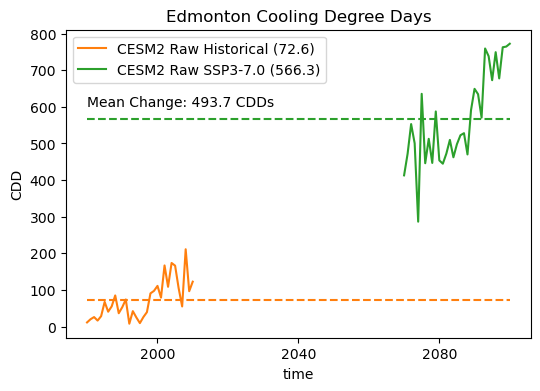

In [24]:
# plot timeseries of annual CDDs for the raw model data
fig, ax = plt.subplots(figsize = (6, 4))
cdd_hist_raw.plot.line(label = "CESM2 Raw Historical (%.1f)" % cdd_hist_raw_ltm.values, color = 'tab:orange')
cdd_ssp3_raw.plot.line(label = "CESM2 Raw SSP3-7.0 (%.1f)" % cdd_ssp3_raw_ltm.values, color = 'tab:green')

# plot long-term means
ax.hlines([cdd_ssp3_raw_ltm.values, cdd_hist_raw_ltm.values], 
          cdd_hist_raw.time.min().values, cdd_ssp3_raw.time.max().values, 
          colors = ['tab:green', 'tab:orange'], linestyles = '--')

ax.set(title = "Edmonton Cooling Degree Days", ylabel = "CDD")
ax.legend()

# show the mean change on the plot
ax.text(cdd_hist_raw.time[0].values, 600, "Mean Change: %.1f CDDs" % (cdd_ssp3_raw_ltm.values - cdd_hist_raw_ltm.values))
plt.show()

In [25]:
# perform two_sample t-test to see if the future period has more CDDs
tstat, pval_cdds = stats.ttest_ind_from_stats(cdd_hist_raw_ltm,
                                              cdd_hist_raw_stdev,
                                              len(cdd_hist_raw.time), # different years should be indep. of each other
                                              cdd_ssp3_raw_ltm,
                                              cdd_ssp3_raw_stdev,
                                              len(cdd_ssp3_raw.time),
                                              equal_var = False,
                                              alternative = 'less') 
# alt hypothesis is that the first dataset (historical) has a lower mean than the second dataset (future)

print("p-value for t-test: %.4f" % pval_cdds)

p-value for t-test: 0.0000


Wow! The raw model projects an enormous increase in annual CDDs, as we suspected based on the large increase in mean summertime temperatures. This should establish our baseline expectation for what to see in the bias-corrected projections. The exact change may be different, but because we are using a univariate method, we should still see a large increase in CDDs for the future scenario.

## 6.1.5 Applying the Bias Correction

In this example, we will use Quantile Delta Mapping (QDM, {cite}`cannon_bias_2015` and Section 4.2.3.3) as the method for bias correction. Since we are using data only for a single location, there is no true "downscaling" involved, as the spatial sampling of the results will be the same as the inputs - a 1D timeseries. This bias-correction method is preferred because it corrects for biases in all quantiles of the distribution of the variable of interest *and* preserves the model-projected relative changes in the entire distribution as well. The former is true for any quantile-mapping based bias-correction method (such as EQM, Section 4.2.3.1), but the latter is the defining feature of QDM. This makes it particularly good for handling changes to extreme values (i.e. high and low quantiles of the distribution), as opposed to other methods which preserve only the mean change projected by the model.

`xclim.sdba` has implementated the QDM method with the class `xclim.sdba.adjustment.QuantileDeltaMapping` ([documentation](https://xclim.readthedocs.io/en/stable/xclim.sdba.html#xclim.sdba.adjustment.QuantileDeltaMapping)). All of the classes in `xclim.sdba.adjust` have a `.train` method, which fits the quantiles and calculates the adjustment factors, and a `.adjust` method, which applies the bias correction to the provided `xr.DataArray`. The content herein will try to demonstrate how to use this package, but you should also take the time to review the documentation for the adjustment method, plus their generic [examples](https://xclim.readthedocs.io/en/stable/notebooks/sdba.html) of how to use `xclim.sdba`, before proceeding. You should also review the tips for applying bias-correction methods provided in Section 5.4.2 of this Guidebook.

In [26]:
# xclim's QM methods don't allow chunking along the time dimension,
# so this will re-chunk the data to a single chunk along the time dimension
tas_hist_raw = tas_hist_raw.chunk({'time': -1})
tas_ssp3_raw = tas_ssp3_raw.chunk({'time': -1})

In [27]:
# estimate the quantiles and calculate the adjustment factors
QDM_trained = sdba.adjustment.QuantileDeltaMapping.train(tas_obs_noleap,      # observational data
                                                         tas_hist_raw, # raw model historical data
                                             # number of quantiles to estimate (see documentation)
                                                         nquantiles = 50, 
             # additive adjustment, for interval variable (see documentation & Cannon et al. 2015)
                                                         kind = "+",
# separate adjustment applied to each month, to correct for bias in seasonal cycle (see documentation)
                                                         group = 'time.month' 
                                                        )

# apply the bias correction to the historical and SSP3-7.0 data
tas_hist_qdm = QDM_trained.adjust(tas_hist_raw, 
                    # how to interpolate between the nquantiles discrete quantile estimates                                  
                                 interp = 'linear')

tas_ssp3_qdm = QDM_trained.adjust(tas_ssp3_raw,                                 
                                  interp = 'linear')

## 6.1.6 Validating the Bias-Corrected Data

As a first check, let's compare the daily climatologies and PDFs of the observed and adjusted historical simulation. The adjusted historical PDF should match the observed PDF essentially perfectly. Since the data are grouped by month when calculating the adjustment factors, the *monthly* climatologies should match perfectly, but there may be some small bias remaining in the daily climatology. We could have chosen to group by `time.dayofyear`, but with only 31 years in each dataset there is probably too small of a sample size to robustly characterize the whole distribution.

In [28]:
# calculate the daily climatologies for the QDM data
tas_hist_qdm_dailyclim = tas_hist_qdm.groupby('time.dayofyear').mean('time').compute()
tas_hist_qdm_dailyclim_stdev = tas_hist_qdm.groupby('time.dayofyear').std('time').compute()

tas_ssp3_qdm_dailyclim = tas_ssp3_qdm.groupby('time.dayofyear').mean('time').compute()
tas_ssp3_qdm_dailyclim_stdev = tas_ssp3_qdm.groupby('time.dayofyear').std('time').compute()

In [29]:
# fit KDE curves for QDM data
kde_hist_qdm = stats.gaussian_kde(tas_hist_qdm.values)
kde_ssp3_qdm = stats.gaussian_kde(tas_ssp3_qdm.values)

# also fit KDE for raw SSP3-7.0 data
kde_ssp3_raw = stats.gaussian_kde(tas_ssp3_raw.values)

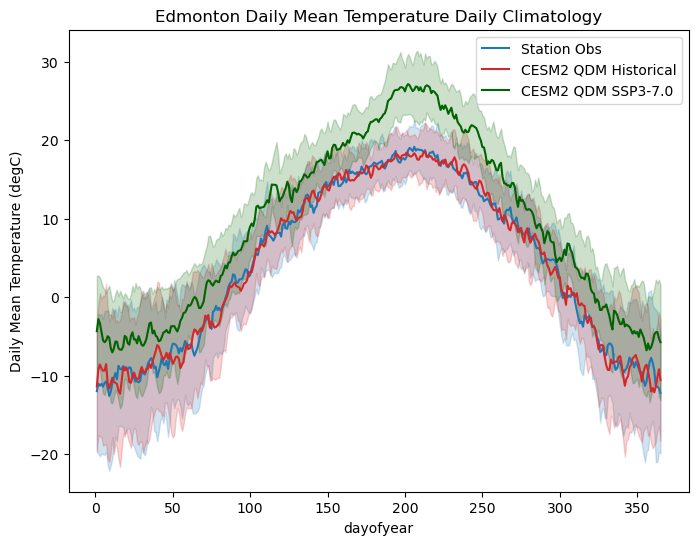

In [30]:
# plot daily climatologies
fig, ax = plt.subplots(figsize = (8,6))

# daily climatologies as 1D curves
tas_dailyclim_obs.plot.line(ax = ax, label = "Station Obs", color = 'tab:blue')
tas_hist_qdm_dailyclim.plot.line(ax = ax, label = "CESM2 QDM Historical", color = 'tab:red')
tas_ssp3_qdm_dailyclim.plot.line(ax = ax, label = "CESM2 QDM SSP3-7.0", color = 'darkgreen')


# 1 sigma shading
# obs
ax.fill_between(tas_dailyclim_obs.dayofyear,
                tas_dailyclim_obs - tas_dailyclim_std_obs, 
                tas_dailyclim_obs + tas_dailyclim_std_obs,
                alpha = 0.2, color = 'tab:blue')
# QDM historical
ax.fill_between(tas_hist_qdm_dailyclim.dayofyear, 
                tas_hist_qdm_dailyclim - tas_hist_qdm_dailyclim_stdev,
                tas_hist_qdm_dailyclim  + tas_hist_qdm_dailyclim_stdev,
                alpha = 0.2, color = 'tab:red')

# QDM SSP3-7.0
ax.fill_between(tas_ssp3_qdm_dailyclim.dayofyear, 
                tas_ssp3_qdm_dailyclim - tas_ssp3_qdm_dailyclim_stdev,
                tas_ssp3_qdm_dailyclim  + tas_ssp3_qdm_dailyclim_stdev,
                alpha = 0.2, color = 'darkgreen')


ax.set_title("Edmonton Daily Mean Temperature Daily Climatology")
ax.set_ylabel("Daily Mean Temperature (degC)")
ax.legend()
plt.show()

The daily climatology of the QDM historical data matches much more closely with the station observations than the raw model did. Most notably, the uncertainty shading shows greater overlap, indicating a better match of the interannual variability for each day of the year. Additionally, the timing of the peak temperatures in the summertime matches better than it did for the raw model.

The bias-adjusted future projections look largely similar to those from the raw model. There is still a very large warming signal in the peak summertime temperatures, though it does not stand out as far from the historical range as it did in the raw model. This is likely because the raw model had a positive bias in summertime temperatures, so the relative increase in the bias-adjusted data is of smaller magnitude.

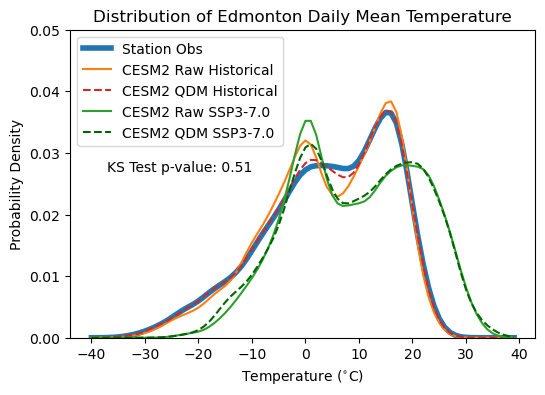

In [31]:
# plot KDEs
plt.figure(figsize = (6,4))
plt.title("Distribution of Edmonton Daily Mean Temperature")
plt.plot(temperatures, kde_obs(temperatures), label = 'Station Obs', color = 'tab:blue', linewidth = 4)

# historical
plt.plot(temperatures, kde_hist_raw(temperatures), label = 'CESM2 Raw Historical', color = 'tab:orange')
plt.plot(temperatures, kde_hist_qdm(temperatures), label = 'CESM2 QDM Historical',
         color = 'tab:red', linestyle = '--')

# SSP3-7.0
plt.plot(temperatures, kde_ssp3_raw(temperatures), label = 'CESM2 Raw SSP3-7.0', color = 'tab:green')
plt.plot(temperatures, kde_ssp3_qdm(temperatures), label = 'CESM2 QDM SSP3-7.0', 
         color = 'darkgreen', linestyle = '--')


plt.ylim(0, 0.05)
plt.xlabel(r"Temperature ($^{\circ}$C)")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper left')

# KS test between QDM historical and obs
pval_ks = stats.ks_2samp(tas_hist_qdm.values, tas_obs_noleap.values).pvalue

plt.text(-37, 0.027, "KS Test p-value: %.2f" % pval_ks)


plt.show()

Comparing the PDFs of the raw model and bias-corrected output, we can see the impact of applying QDM. The bias-adjusted historical simulation matches the observed PDF much more closely, though it still has a slightly higher low-temperature peak than the observations. This may be an artefact introduced by the monthly grouping - we enforced that the distributions for each month of the year must match individually, not the overall distribution. We can test if the bias-adjusted data follows a significantly different distribution than the observations using the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), like in Section 4.4.1. The null hypothesis of this test is that both samples being compared are drawn from the same underlying probability distribution. The p-value of 0.51 is sufficiently high that we fail to reject the null hypothesis, and thus there isn't sufficient evidence to claim that they follow different sampling distributions.

The effect of the bias adjustment on the SSP3-7.0 projections is fairly minor, though it does weaken the low-temperature peka of the PDF, much like it does for the historical distribution. Whether this leads to any substantial change in the projections of CDDs is difficult to discern from looking at the PDF. All in all, the bias was fairly minimal for this model, so it's no surprise that the effect of the bias adjustment is marginal.


## 6.1.7 Downscaled Projections of our Climate Indicator

Next we will investigate the effect of the bias adjustment on the calculation of CDDs, including both validating the downscaled historical data and assessing the changes to the downscaled future projections.

In [32]:
# calculate CDDs
cdd_hist_qdm = xci.cooling_degree_days(tas_hist_qdm).compute()
cdd_ssp3_qdm = xci.cooling_degree_days(tas_ssp3_qdm).compute()

# long-term means
cdd_hist_qdm_ltm = cdd_hist_qdm.mean('time').compute()
cdd_ssp3_qdm_ltm = cdd_ssp3_qdm.mean('time').compute()

# stdevs
cdd_hist_qdm_stdev = cdd_hist_qdm.std('time').compute()
cdd_ssp3_qdm_stdev = cdd_ssp3_qdm.std('time').compute()

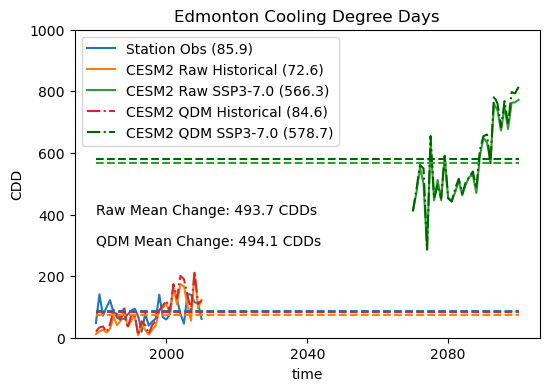

In [33]:
# plot timeseries of annual CDDs for the downscaled model data
fig, ax = plt.subplots(figsize = (6, 4))
cdd_obs.plot.line(label = "Station Obs (%.1f)" % cdd_obs_ltm.values, color = 'tab:blue')
cdd_hist_raw.plot.line(label = "CESM2 Raw Historical (%.1f)" % cdd_hist_raw_ltm.values, color = 'tab:orange')
cdd_ssp3_raw.plot.line(label = "CESM2 Raw SSP3-7.0 (%.1f)" % cdd_ssp3_raw_ltm.values, color = 'tab:green')

cdd_hist_qdm.plot.line(label = "CESM2 QDM Historical (%.1f)" % cdd_hist_qdm_ltm.values, 
                       color = 'tab:red', linestyle ='-.')
cdd_ssp3_qdm.plot.line(label = "CESM2 QDM SSP3-7.0 (%.1f)" % cdd_ssp3_qdm_ltm.values, 
                       color = 'darkgreen', linestyle ='-.')

# plot long-term means
ax.hlines([cdd_obs_ltm.values, cdd_ssp3_raw_ltm.values, cdd_hist_raw_ltm.values,
          cdd_hist_qdm_ltm.values, cdd_ssp3_qdm_ltm.values], 
          cdd_hist_raw.time.min().values, cdd_ssp3_raw.time.max().values, 
          colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'darkgreen'], linestyles = '--')

ax.set(title = "Edmonton Cooling Degree Days", ylabel = "CDD", ylim = (0, 1000))
ax.legend()

# show the mean change on the plot
ax.text(cdd_hist_raw.time[0].values, 400, 
        "Raw Mean Change: %.1f CDDs" % (cdd_ssp3_raw_ltm.values - cdd_hist_raw_ltm.values))
ax.text(cdd_hist_raw.time[0].values, 300, 
        "QDM Mean Change: %.1f CDDs" % (cdd_ssp3_qdm_ltm.values - cdd_hist_qdm_ltm.values))
plt.show()

The effect of the bias adjustment on the model historical CDDs is positive - the mean number of annual CDDs is very close to the observed long-term mean. The number of future CDDs also increases as a result of the bias correction, but the mean change is essentially unchanged. This behavior might lead you to question whether the bias correction was worth it at all, but remember that this model had a very low bias in daily mean temperature for our study site. Other models, which we'll investigate in the next section, may not show the same behavior.